# [모듈 1.1] Real-Time Endpoint 배포 및 추론
---

본 워크샵의 모든 노트북은 `conda_python3` 추가 패키지를 설치하고 모두 이 커널 에서 작업 합니다.

이 노트북은 아래와 같은 작업을 합니다.

- 1. 환경 셋업
- 2. 모델 패키징
- 3. SageMaker Endpoint Deployment
- 4. Inference
- 5. 테스트 데이터 추론 및 성능 평가
- 6. 엔드 포인트 삭제



---

### 참고
- 김대근님의 리포에서 SageMaker Hugging Face Inference Toolkit 등을 자세히 설명 함.
    - [Lab 2-1: Deploy Hugging Face Transformers in SageMaker Real-time Endpoint](https://github.com/daekeun-ml/sm-huggingface-kornlp/blob/main/lab_2_serving/1_real_time_endpoint.ipynb)
    
    
- HF 공식 사이트 에서 SM Endpint 를 배포하는 가이드
    - [Deploy models to Amazon SageMaker](https://huggingface.co/docs/sagemaker/inference#deploy-a-🤗-transformers-model-trained-in-sagemaker)
    
    
- SageMaker Hugging Face Inference Toolkit: 
    - https://github.com/aws/sagemaker-huggingface-inference-toolkit    

# 1. 환경 셋업

## 기본 세팅
사용하는 패키지는 import 시점에 다시 재로딩 합니다.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# 서빙 코드
sys.path.append('./src')
# 훈련 코드
sys.path.append('../3_Training/src')

In [19]:
%store -r bucket
%store -r prefix
# HF Trainer 훈련시
%store -r trainer_artifact_path
# 파이 토치로 훈련시
%store -r artifact_path 


no stored variable or alias artifact_path


### HF Trainer 로 훈련시에 아티펙트를 지정 함.
- pytorch 시에 아래 제거 하세요

In [23]:
artifact_path = trainer_artifact_path

In [3]:
### 커스텀 라이브러리
import config 

In [4]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()



In [5]:
import os
import json
import sys
import logging
import boto3
import sagemaker
from sagemaker.huggingface import HuggingFaceModel
from sagemaker import session
from transformers import ElectraConfig
from transformers import (
    ElectraModel, ElectraTokenizer, ElectraForSequenceClassification
)

logging.basicConfig(
    level=logging.INFO, 
    format='[{%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(filename='tmp.log'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# 2. 모델 패키징
- 모델 아티펙트를 다운로드 합니다.
- 다운로드 받은 모델 아티펙트의 압축을 해제하고 모델 가중치인 model.pth 파일을 얻습니다.

In [6]:
import os
import config

model_data_dir = config.model_dir
os.makedirs(model_data_dir, exist_ok=True)
print("model_data_dir: ", model_data_dir)

model_data_dir:  models/nsmc


### 모델 패키징 폴더 정리

In [7]:
%%sh -s {model_data_dir}

model_data_dir=$1

echo $model_data_dir

# 기존 데이터 삭제
rm -rf $model_data_dir/*


models/nsmc


### 모델 및 토큰나이저 아티펙트 다운로드

In [8]:
tokenizer_id = config.tokenizer_id
model_id = config.model_id

print(f"tokenizer_id: {tokenizer_id}")
print(f"model_id: {model_id}")

# Download model and tokenizer
model = ElectraForSequenceClassification.from_pretrained(model_id)
tokenizer = ElectraTokenizer.from_pretrained(tokenizer_id)

# os.makedirs(model_dir, exist_ok=True)
model.save_pretrained(model_data_dir)
tokenizer.save_pretrained(model_data_dir)

tokenizer_id: monologg/koelectra-small-v3-discriminator
model_id: monologg/koelectra-small-v3-discriminator


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. in

('models/nsmc/tokenizer_config.json',
 'models/nsmc/special_tokens_map.json',
 'models/nsmc/vocab.txt',
 'models/nsmc/added_tokens.json')

### pre-trained 모델 가중치 삭제

In [16]:
%%sh -s {model_data_dir}

model_data_dir=$1

echo $model_data_dir
cd $model_data_dir


# 기존 모델 삭제ㅁ
rm -rf pytorch_model.bin


models/nsmc


### fine-tunnig 된 모델 가중치 다운로드
- 파이토치로 훈련시에 가중치를 약속된 pytorch_model.bin 이름으로 변경
- 아래 셀에서 다음을 주석 제거 하세요.

```# mv sentimental-electro-hf.pth pytorch_model.bin```



In [24]:
! aws s3 ls {artifact_path} 

2022-06-14 13:15:09   52546441 model.tar.gz


In [25]:
%%sh -s {artifact_path} {model_data_dir}

artifact_path=$1
model_data_dir=$2

echo $artifact_path
echo $model_data_dir


# 모델을 S3에서 로컬로 다운로드
aws s3 cp $artifact_path $model_data_dir

# 모델 다운로드 폴더로 이동
cd $model_data_dir

# 압축 해제
tar -xvf model.tar.gz  

rm -rf model.tar.gz  

# 파이토치 훈련시에 훈련된 가중치를 약속된 pytorch_model.bin 이름으로 변경ㅁ
# mv sentimental-electro-hf.pth pytorch_model.bin


s3://sagemaker-us-east-1-057716757052/huggingface-native-pytorch-190-hol-2022-2022-06-14-13-01-57-447/output/model.tar.gz
models/nsmc
download: s3://sagemaker-us-east-1-057716757052/huggingface-native-pytorch-190-hol-2022-2022-06-14-13-01-57-447/output/model.tar.gz to models/nsmc/model.tar.gz
training_args.bin
pytorch_model.bin
config.json


### 모델 아테펙트를 model.tar.gz 로 압축

모델 파라메터 및 토크나이저를 `model.tar.gz`으로 압축합니다. 압축 파일명은 자유롭게 지정할 수 있으나, 반드시 `tar.gz`로 압축해야 합니다.

In [26]:
model_artifact_name = 'model.tar.gz'
!cd {model_data_dir} && tar -czvf {model_artifact_name} *.*

config.json
pytorch_model.bin
special_tokens_map.json
tokenizer_config.json
training_args.bin
vocab.txt


### model.tar.gz 를 S3 에 업로드ㅡ

In [27]:
s3_prefix = prefix
s3_model_path = f's3://{bucket}/{s3_prefix}'
!aws s3 cp {model_data_dir}/{model_artifact_name} {s3_model_path}/{model_artifact_name}

print("s3_model_path: \n", s3_model_path)

upload: models/nsmc/model.tar.gz to s3://sagemaker-us-east-1-057716757052/KoElectra-HF/model.tar.gz
s3_model_path: 
 s3://sagemaker-us-east-1-057716757052/KoElectra-HF


모델 파라메터 및 토크나이저를 `model.tar.gz`으로 압축합니다. 압축 파일명은 자유롭게 지정할 수 있으나, 반드시 `tar.gz`로 압축해야 합니다.

# 3. SageMaker Endpoint Deployment

## 3.1. 앤드포인트 배포
 
아래 코드를 보시면 아시겠지만, 지속적으로 업데이트되는 파이썬 버전&프레임워크 버전&트랜스포머 버전에 쉽게 대응할 수 있습니다. AWS에서 관리하고 있는 딥러닝 컨테이너(DLC) 목록을 아래 주소에서 확인해 보세요.

- https://github.com/aws/deep-learning-containers/blob/master/available_images.md

In [28]:
# local_model_path = os.path.join(config.model_dir, 'model.tar.gz')
# print("local_model_path: ", local_model_path)

In [29]:
# instance_type = "ml.m5.xlarge"
instance_type = 'ml.g4dn.xlarge' # $ 0.906 per Hour

In [30]:
# create Hugging Face Model Class
hf_model = HuggingFaceModel(
    model_data=f"{s3_model_path}/{model_artifact_name}",  # path to your trained SageMaker model
    role=role,                                            # IAM role with permissions to create an endpoint
    transformers_version="4.11.0",                        # Transformers version used
    pytorch_version="1.9.0",                              # PyTorch version used
    py_version='py38',                                    # Python version used
    
)

# deploy model to SageMaker Inference
hf_predictor = hf_model.deploy(
    initial_instance_count=1,
    instance_type= instance_type,
    wait=False
)

[{session.py:2668} INFO - Creating model with name: huggingface-pytorch-inference-2022-06-14-13-38-29-302
[{session.py:3585} INFO - Creating endpoint-config with name huggingface-pytorch-inference-2022-06-14-13-38-29-592
[{session.py:3053} INFO - Creating endpoint with name huggingface-pytorch-inference-2022-06-14-13-38-29-592


In [31]:
%%time 
sess.wait_for_endpoint(hf_predictor.endpoint_name, poll=5)

---------------------------------------------------------------!CPU times: user 247 ms, sys: 20.9 ms, total: 268 ms
Wall time: 5min 18s


{'EndpointName': 'huggingface-pytorch-inference-2022-06-14-13-38-29-592',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:057716757052:endpoint/huggingface-pytorch-inference-2022-06-14-13-38-29-592',
 'EndpointConfigName': 'huggingface-pytorch-inference-2022-06-14-13-38-29-592',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.9.0-transformers4.11.0-gpu-py38-cu111-ubuntu20.04',
     'ResolvedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference@sha256:b1a3fd4369a4364e153f390d81bd11b49f2c0b8193ad565b4886f10326c2c6b1',
     'ResolutionTime': datetime.datetime(2022, 6, 14, 13, 38, 30, 578000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 6, 14, 13, 38, 29, 835000, tzinfo=tzlocal()),


## 3.2. Wait for the endpoint jobs to complete

엔드포인트가 생성될 때까지 기다립니다. 약 5-10분의 시간이 소요됩니다.

In [32]:
from IPython.core.display import display, HTML

def make_endpoint_link(region, endpoint_name, endpoint_task):
    
    endpoint_link = f'<b><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/endpoints/{endpoint_name}">{endpoint_task} Review Endpoint</a></b>'   
    return endpoint_link 
        
endpoint_link1 = make_endpoint_link(region, hf_predictor.endpoint_name, '[Deploy model from S3]')


display(HTML(endpoint_link1))

<br>

# 4. Inference

---

두 개의 엔드포인트가 배포되었습니다. 샘플 데이터로 직접 추론을 수행해 봅니다.

## 4.1. SageMaker Python SDK 추론

In [33]:
# example request, you always need to define "inputs"
payload = {
   "inputs": [
       "정말 재미있습니다. 세 번 봐도 질리지 않아요.",
       "시간이 아깝습니다. 다른 영화를 보세요."
   ]
}

In [34]:
hf_predictor.predict(payload)

[{'label': 'positive', 'score': 0.988431990146637},
 {'label': 'negative', 'score': 0.985621988773346}]

## 4.2. Botoe3 추론

In [35]:
import boto3

runtime_client = boto3.Session().client('sagemaker-runtime')


In [36]:
import time
import json
from inference_utils import invoke_endpoint_hf
payload_dump = json.dumps(payload)

start_time = time.time()
result = invoke_endpoint_hf(runtime_client, hf_predictor.endpoint_name, 
                         payload_dump,
                         content_type='application/json'
                        )

print("--- %s seconds ---" % (time.time() - start_time))
print('result: ', result)

--- 0.34906554222106934 seconds ---
result:  [{'label': 'positive', 'score': 0.988431990146637}, {'label': 'negative', 'score': 0.985621988773346}]


# 5. 테스트 데이터 추론 및 성능 평가

## 5.1. 테스트 데이터 로딩

In [37]:
test_file_path = '../3_Training/data/nsmc/test/ratings_test.txt'

In [38]:
from data_util import read_nsmc_split
from inference_utils import inference_batch, plot_confusion_matrix

# 훈련 Text, Label 로딩    
test_texts, test_labels = read_nsmc_split(test_file_path)



In [70]:
import pandas as pd
test_df = pd.DataFrame(data=list(zip(test_texts, test_labels)), 
                       columns=['doc','label'])
print("test_df shape: ", test_df.shape)
sample_df = test_df[0:50000]
# sample_df = test_df[0:200]
sample_df.shape



test_df shape:  (49832, 2)


(49832, 2)

## 5.2. 배치 단위로 추론
-- 약 10 분 정도 소요 됨

In [71]:
%%time 

chunk_size = 1024
pred_list, score_list = inference_batch(sample_df, chunk_size, runtime_client, hf_predictor)


test samples 5120 is done
test samples 10240 is done
test samples 15360 is done
test samples 20480 is done
test samples 25600 is done
test samples 30720 is done
test samples 35840 is done
test samples 40960 is done
test samples 46080 is done
CPU times: user 507 ms, sys: 0 ns, total: 507 ms
Wall time: 8min 41s


## 5.3. 기존 테스트 데이터에 실험 데이터 추가

In [72]:
sample_df.insert(len(sample_df.columns), column='pred', value=pred_list)
sample_df.insert(len(sample_df.columns), column='score', value=score_list)

In [73]:
sample_df.head()

,doc,label,pred,score
0,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,0,0.950
1,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,0,0.963
2,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,0,0.758
3,음악이 주가 된 최고의 음악영화,1,1,0.986
4,진정한 쓰레기,0,0,0.989


## 5.4. 정확도 및 혼돈 행렬 확인

In [74]:
y_true = sample_df.label.tolist()
y_pred = sample_df.pred.tolist()


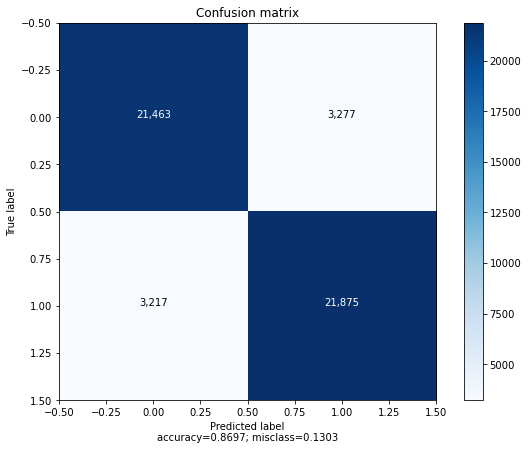

In [75]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cf, normalize=False)

# 6. 엔드 포인트 삭제
- 기존에 생성한 로컬 세이지 메이커 모델, 앤드포인트 컨피그, 앤드포인트 삭제

In [76]:
from inference_utils import delete_endpoint

client = boto3.Session().client('sagemaker')
delete_endpoint(client, hf_predictor.endpoint_name)

--- Deleted model: huggingface-pytorch-inference-2022-06-14-13-38-29-302
--- Deleted endpoint: huggingface-pytorch-inference-2022-06-14-13-38-29-592
--- Deleted endpoint_config: huggingface-pytorch-inference-2022-06-14-13-38-29-592
